In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

# NEST installation directory path
NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### NESTML code generation

Assume that our NESTML input model is called `iaf_psc_exp_multisyn_exc.nestml`. To generate code and build a dynamic library that can be loaded as a user module in NEST Simulator:

In [2]:
# Get the absolute path to the parent directory of the current working directory
repo_parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get the absolute path to the main directory of the repository
repo_main_dir = os.path.abspath(os.path.join(repo_parent_dir, os.pardir))

# Get the absolute path to the NESTML model
nestml_model_dir = os.path.join(repo_main_dir, "src" , "nestml_models", "iaf_psc_exp_multisyn_exc_neuron.nestml")

print(nestml_model_dir)

/home/shimoura/Github/humam-add-nmda-synapses/src/nestml_models/iaf_psc_exp_multisyn_exc_neuron.nestml


In [3]:
# generate_target(input_path=nestml_model_dir,
#                 target_platform="NEST",
#                 target_path="/tmp/nestml-component",
#                 logging_level="INFO"
#                 )

module_name, neuron_model_name = NESTCodeGeneratorUtils.generate_code_for(nestml_model_dir,
                                                                          module_name="ampa_nmda_module",)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



CMake Warning (dev) at CMakeLists.txt:93 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU 13.3.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /home/shimoura/miniforge3/envs/humam-nest3/bin/x86_64-conda-linux-gnu-c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
ampa_nmda_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /home/shimoura/miniforge3/envs/humam-nest3/bin/x86_64-conda-linux-gnu-c++
Build static libs    : OFF
C++ compiler flags   : -fvisibility-inlines-hidden -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vec

### Instantiate model in NEST Simulator and run

Using the PyNEST API, the model can be instantiated and simulated in NEST. The following code will create one instance of the neuron model (`nest.Create("iaf_psc_exp_multisynex")`), inject a pulse current coming from a pre-synaptic spike and run for 500 ms.

In [4]:
model_params_e = {
                # Leak potential of the neurons (in mV).
                # See Allen Cells GLIF Parameters.ipynb
                'E_L': -70.0,
                # Threshold potential of the neurons (in mV).
                # See Allen Cells GLIF Parameters.ipynb
                'V_th': -45.0,
                # Membrane potential after a spike (in mV).
                # See Allen Cells GLIF Parameters.ipynb
                'V_reset': -70.0,
                # Membrane capacitance (in pF).
                # See Allen Cells GLIF Parameters.ipynb
                'C_m': 300.0,
                # Membrane time constant (in ms).
                # See Allen Cells GLIF Parameters.ipynb
                # Lowered to account for high-conductance state.
                'tau_m': 10.0,
                # Time constant of postsynaptic excitatory currents (in ms).
                # Value for AMPA receptors from (Fourcaud & Brunel, 2002)
                'tau_syn_exc_AMPA': 2.0,
                # Value for NMDA receptors
                'tau_syn_exc_NMDA': 100.0,
                # Time constant of postsynaptic inhibitory currents (in ms).
                # Value for GABA_A receptors from (Fourcaud & Brunel, 2002)
                'tau_syn_inh': 5.0,
                # Refractory period of the neurons after a spike (in ms).
                't_ref': 2.0,
                'r_NMDA': 2.0,
                }

Text(0.5, 0, 'Time [ms]')

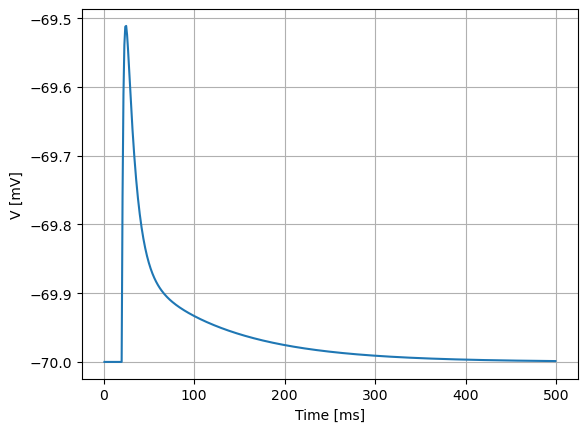

In [5]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()
nest.Install(module_name)

neuron = nest.Create(neuron_model_name)
nest.SetStatus(neuron, model_params_e)
voltmeter = nest.Create("voltmeter")

voltmeter.set({"record_from": ["V_m"]})
nest.Connect(voltmeter, neuron)

sg = nest.Create("spike_generator", params={"spike_times": [20.]})
nest.Connect(sg, neuron, syn_spec={"weight": 100., "delay": 0.1})

sr = nest.Create("spike_recorder")
nest.Connect(neuron, sr)

nest.Simulate(500.)

spike_times = nest.GetStatus(sr, keys='events')[0]['times']

fig, ax = plt.subplots(nrows=1)
ax.plot(voltmeter.get("events")["times"], voltmeter.get("events")["V_m"])
ax.scatter(spike_times, 30 * np.ones_like(spike_times), marker="d", c="orange", alpha=.8, zorder=99)
ax.grid(True)
ax.set_ylabel("V [mV]")
ax.set_xlabel("Time [ms]")

In [6]:
nest.GetStatus(nest.GetConnections(target=neuron, source=sg))

({'delay': 0.1,
  'port': 0,
  'receptor': 0,
  'sizeof': 32,
  'source': 3,
  'synapse_id': 26,
  'synapse_model': 'static_synapse',
  'target': 1,
  'target_thread': 0,
  'weight': 100.0},)